# Smiles Image: Pytorch Binary Classification
This workbook illustrates binary classification of `Smiles Dataset` using a Pytorch based binary classifier. The dataset is available at [this GitHub location](https://github.com/hromi/SMILEsmileD)

In [ ]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

In [1]:
# Run this ONLY in Colab (For some reason, Colab does not have torchmetrics installed)
if USE_COLAB:
    !pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 9.6 MB/s eta 0:00:00


In [2]:
import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Connect to Google drive, so I can import modules from it into my workspace
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "ColabNotebooks/")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys, pathlib
        pyt_path = os.path.join(COLAB_NOTEBOOKS_PATH, 'Pytorch')
        sys.path.append(pyt_path)
        print('You Pytorch Colab notebooks are available at ', pyt_path)
        print('NOTE: {} is appended to sys.path!'.format(pyt_path))
        # and test it
        import pytorch_training_toolkit as t3
        save_path = pathlib.Path("/content") / "model_states"
        if not save_path.exists():
            save_path.mkdir()
        MODEL_SAVE_DIR = save_path.__str__()
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

assert os.path.exists(MODEL_SAVE_DIR)
print('MODEL_SAVE_DIR = %s' % MODEL_SAVE_DIR)

Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Pytorch Colab notebooks are available at  /content/drive/My Drive/ColabNotebooks/Pytorch
NOTE: /content/drive/My Drive/ColabNotebooks/Pytorch is appended to sys.path!
MODEL_SAVE_DIR = /content/model_states


In [3]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.0)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version: %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "is NOT"))
import torch.nn as nn
from torchvision import datasets, transforms
import torchsummary
# My helper functions for training/evaluating etc.
if USE_COLAB:
    # single file code (as Colab appears to have issues importing Modules)
    import pytorch_training_toolkit as t3
else:
    import torch_training_toolkit as t3

SEED = 42
t3.seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Will train model on {DEVICE}")

Using Pytorch version: 1.13.1+cu116. GPU IS available
Will train model on cuda


In [4]:
# download the data from GitHub 
if USE_COLAB:
    !git clone https://github.com/hromi/SMILEsmileD.git /content/data/SMILEsmileD
else:
    !git clone https://github.com/hromi/SMILEsmileD.git ../data/SMILEsmileD

Cloning into '/content/data/SMILEsmileD'...
remote: Enumerating objects: 13190, done.
remote: Total 13190 (delta 0), reused 0 (delta 0), pack-reused 13190
Receiving objects: 100% (13190/13190), 37.48 MiB | 31.33 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [5]:
if USE_COLAB:
    IMAGES_BASE_PATH = (pathlib.Path("/content") / 'data' / 'SMILEsmileD' / 'SMILEs').__str__()
else:
    IMAGES_BASE_PATH = (pathlib.Path.cwd().parents[0] / 'data' / 'SMILEsmileD' / 'SMILEs').__str__()
print(IMAGES_BASE_PATH)


image_transforms = transforms.Compose([
    transforms.ToTensor()   
])

smiles_dataset = datasets.ImageFolder(IMAGES_BASE_PATH, transform=image_transforms)
print(f"Total number of images {len(smiles_dataset)}")
train_dataset, test_dataset = t3.split_dataset(smiles_dataset, split_perc=0.3)
val_dataset, test_dataset = t3.split_dataset(test_dataset, split_perc=0.1)
print(f"No of images in train_dataset: {len(train_dataset)} - cross-val: {len(val_dataset)} - test: {len(test_dataset)}")

/content/data/SMILEsmileD/SMILEs
Total number of images 13165
No of images in train_dataset: 9215 - cross-val: 3555 - test: 395


images.shape: (64, 3, 64, 64) - labels.shape: (64,)


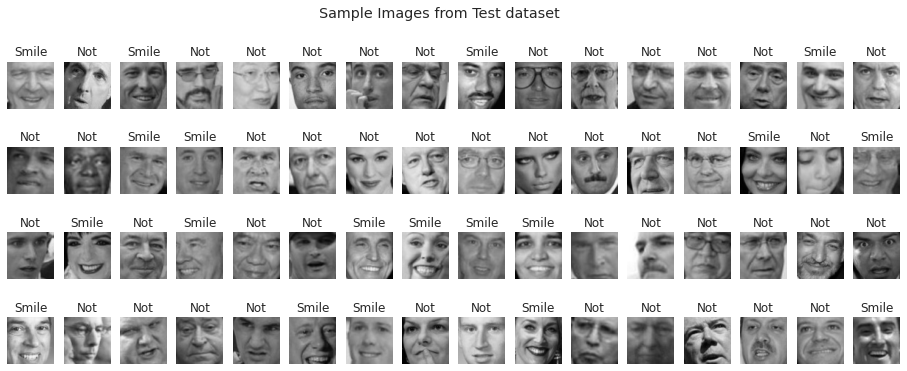

In [6]:
# display some images from train_dataset
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

plt.figure(figsize=(16, 6))
for i in range(64):
    plt.subplot(4, 16, i + 1)
    image = sample_images[i]
    # label_text = "Pos" if sample_labels[i] == 1 else "Neg"
    label_text = "Smile" if sample_labels[i] == 1 else "Not"
    # print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1, 2, 0))
    # print(f" - AP: images[{i}].shape: {image.shape}")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(label_text)
    plt.axis('off')
plt.suptitle("Sample Images from Test dataset")
plt.show()
plt.close()


In [9]:
# build our model
class SmilesModule(nn.Module):
    def __init__(self):
        super(SmilesModule, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=1),  # 20
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),

            nn.Conv2d(32, 64, kernel_size=5, padding=1),  # 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),

            nn.Conv2d(64, 128, kernel_size=5, padding=1),  # 32
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),

            nn.Flatten(),
            nn.Dropout(0.3),

            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.net(x)

In [10]:
model = SmilesModule()
model = model.to(DEVICE)
print(torchsummary.summary(model, (3, 64, 64)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]           2,432
              ReLU-2           [-1, 32, 62, 62]               0
       BatchNorm2d-3           [-1, 32, 62, 62]              64
         MaxPool2d-4           [-1, 32, 31, 31]               0
           Dropout-5           [-1, 32, 31, 31]               0
            Conv2d-6           [-1, 64, 29, 29]          51,264
              ReLU-7           [-1, 64, 29, 29]               0
       BatchNorm2d-8           [-1, 64, 29, 29]             128
         MaxPool2d-9           [-1, 64, 14, 14]               0
          Dropout-10           [-1, 64, 14, 14]               0
           Conv2d-11          [-1, 128, 12, 12]         204,928
             ReLU-12          [-1, 128, 12, 12]               0
      BatchNorm2d-13          [-1, 128, 12, 12]             256
        MaxPool2d-14            [-1, 12

## Training the model

In [11]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 32, 32, 3, 2
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_LAMBDA = (50 if USE_COLAB else 25), 64, 1e-2, 1e-2
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, "pyt_smiles.pt")

In [12]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

metrics_map = {
    "acc" : MulticlassAccuracy(num_classes=NUM_CLASSES),
    "f1" : MulticlassF1Score(num_classes=NUM_CLASSES)
}
loss_fn = torch.nn.CrossEntropyLoss()

trainer = t3.Trainer(
    loss_fn=loss_fn, device=DEVICE, metrics_map=metrics_map,
    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
)

In [15]:
from torch.optim.lr_scheduler import StepLR
model = SmilesModule()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
scheduler = StepLR(optimizer, step_size=NUM_EPOCHS//10, gamma=0.1)
hist = trainer.fit(
    model, optimizer, train_dataset, validation_dataset=val_dataset, 
    lr_scheduler=scheduler,
    # l2_reg=L2_LAMBDA
)

Cross training on 'cuda' with 9215 training and 3555 cross-validation records...
Epoch ( 1/50): (9215/9215) -> loss: 1.4065 - acc: 0.6657 - f1: 0.6565 - val_loss: 0.8747 - val_acc: 0.6073 - val_f1: 0.6099
Epoch ( 2/50): (9215/9215) -> loss: 0.4428 - acc: 0.7551 - f1: 0.7568 - val_loss: 0.4546 - val_acc: 0.6559 - val_f1: 0.6729
Epoch ( 3/50): (9215/9215) -> loss: 0.3598 - acc: 0.7975 - f1: 0.8040 - val_loss: 0.4044 - val_acc: 0.8585 - val_f1: 0.8232
Epoch ( 4/50): (9215/9215) -> loss: 0.3312 - acc: 0.8119 - f1: 0.8213 - val_loss: 0.4048 - val_acc: 0.6355 - val_f1: 0.6457
Epoch ( 5/50): (9215/9215) -> loss: 0.3448 - acc: 0.8046 - f1: 0.8140 - val_loss: 0.3538 - val_acc: 0.8318 - val_f1: 0.8471
Epoch ( 6/50): (9215/9215) -> loss: 0.2729 - acc: 0.8557 - f1: 0.8652 - val_loss: 0.2450 - val_acc: 0.8941 - val_f1: 0.8797
Epoch ( 7/50): (9215/9215) -> loss: 0.2465 - acc: 0.8691 - f1: 0.8757 - val_loss: 0.2184 - val_acc: 0.8647 - val_f1: 0.8798
Epoch ( 8/50): (9215/9215) -> loss: 0.2396 - acc: 0

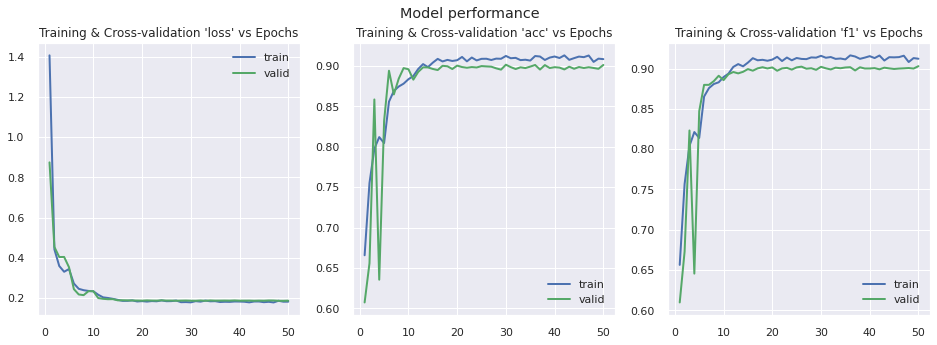

In [16]:
hist.plot_metrics(title="Model performance")

In [17]:
print("Evaluating model...")
metrics = trainer.evaluate(model, train_dataset)
print(f"  Training dataset  -> loss: {metrics['loss']:.3f} - acc: {metrics['acc']:.3f}")
metrics = trainer.evaluate(model, val_dataset)
print(f"  Cross-val dataset -> loss: {metrics['loss']:.3f} - acc: {metrics['acc']:.3f}")
metrics = trainer.evaluate(model, test_dataset)
print(f"  Test dataset      -> loss: {metrics['loss']:.3f} - acc: {metrics['acc']:.3f}")

Evaluating model...
Evaluating (9215/9215) -> loss: 0.1501 - acc: 0.9277 - f1: 0.9291
  Training dataset  -> loss: 0.150 - acc: 0.928
Evaluating (3555/3555) -> loss: 0.1881 - acc: 0.8995 - f1: 0.9011
  Cross-val dataset -> loss: 0.188 - acc: 0.900
Evaluating (395/395) -> loss: 0.2238 - acc: 0.8963 - f1: 0.8791
  Test dataset      -> loss: 0.224 - acc: 0.896


In [18]:
t3.save_model(model, MODEL_SAVE_PATH)
del model

Pytorch model saved to /content/model_states/pyt_smiles.pt


## Run Predictions

In [19]:
model = SmilesModule()
model = model.to(DEVICE)
model = t3.load_model(model, MODEL_SAVE_PATH)
print(torchsummary.summary(model, (3, 64, 64)))

Pytorch model loaded from /content/model_states/pyt_smiles.pt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]           2,432
              ReLU-2           [-1, 32, 62, 62]               0
       BatchNorm2d-3           [-1, 32, 62, 62]              64
         MaxPool2d-4           [-1, 32, 31, 31]               0
           Dropout-5           [-1, 32, 31, 31]               0
            Conv2d-6           [-1, 64, 29, 29]          51,264
              ReLU-7           [-1, 64, 29, 29]               0
       BatchNorm2d-8           [-1, 64, 29, 29]             128
         MaxPool2d-9           [-1, 64, 14, 14]               0
          Dropout-10           [-1, 64, 14, 14]               0
           Conv2d-11          [-1, 128, 12, 12]         204,928
             ReLU-12          [-1, 128, 12, 12]               0
      BatchNorm2d-13          [-1, 128, 1

In [20]:
y_pred, y_true = trainer.predict(model, test_dataset)
y_pred = np.argmax(y_pred, axis=1)
correct_preds = (y_pred == y_true).sum()
pred_acc = correct_preds / len(y_true)
print(f"We got {correct_preds} predictions of {len(y_true)} samples correct! Test acc: {pred_acc*100.0:.3f}%")

rand_indexes = np.random.randint(0, len(y_true), 64)
print(f"Actuals (50 random samples)    : {y_true[rand_indexes]}")
print(f"Predictions (50 random samples): {y_pred[rand_indexes]}")

We got 361 predictions of 395 samples correct! Test acc: 91.392%
Actuals (50 random samples)    : [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0]
Predictions (50 random samples): [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0]


images.shape: (64, 3, 64, 64) - labels.shape: (64,)


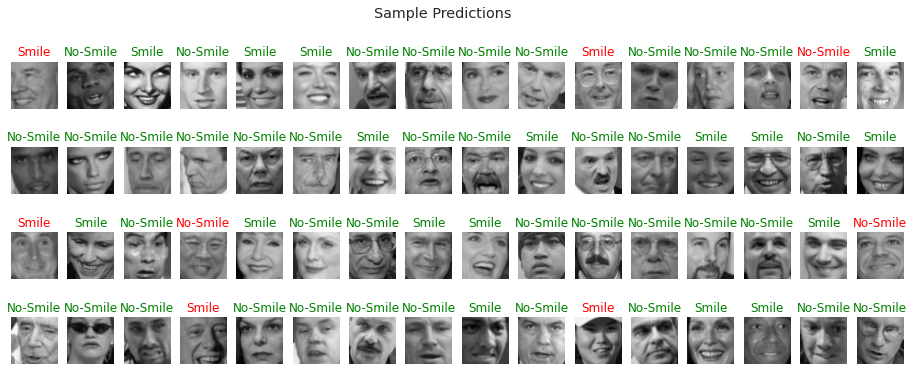

In [21]:
NUM_SAMPLES = 64
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=NUM_SAMPLES, shuffle=False)
data_iter = iter(trainloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
predictions = y_pred[:NUM_SAMPLES]
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

plt.figure(figsize=(16, 6))
for i in range(NUM_SAMPLES):
    plt.subplot(4, 16, i + 1)
    image = sample_images[i]
    # label_text = "Pos" if sample_labels[i] == 1 else "Neg"
    label_text = "Smile" if sample_labels[i] == 1 else "No-Smile"
    # print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1, 2, 0))
    # print(f" - AP: images[{i}].shape: {image.shape}")
    plt.imshow(image.squeeze(), cmap='gray')
    title = plt.title(label_text)
    plt.setp(title, color=("g" if sample_labels[i] == y_pred[i] else "r"))
    plt.axis('off')
plt.suptitle("Sample Predictions")
plt.show()
plt.close()

In [22]:
del model

# <center> -- END -- </center>